<div align="center">
    <img src="https://netspresso-docs-imgs.s3.ap-northeast-2.amazonaws.com/imgs/banner/pynp_main.png"/>
</div>

# **PyNetsPresso Tutorial**

We will explain the process of optimizing the AI model with PyNetsPresso.

In this tutorial, we will cover:

- Train YOLOX detection model. (with **Trainer**)
- Benchmark the trained model. (with **Converter & Benchmarker**)
- Optimize the trained model to satisfies the target latency. (with **Compressor**)
- Retrain the compressed model that satisfies the target latency. (with **Trainer**)
- Comparison of performance between original model and compressed model.

In [1]:
import os

from netspresso import ModelTrainer, ModelCompressor, ModelConverter, ModelBenchmarker
from netspresso.client import SessionClient
from netspresso.trainer import Task, Resize
from netspresso.compressor import Framework
from netspresso.launcher import ModelFramework, DeviceName
from loguru import logger
import numpy as np
import matplotlib.pyplot as plt
import torch

2023-12-20 08:21:38.654 | INFO     | netspresso.client.config:<module>:10 - Read prod config


To use the PyNetsPresso, please enter the email and password registered in NetsPresso.

In [2]:
EMAIL = "YOUR_EMAIL"
PASSWORD = "YOUR_PASSWORD"

## 1. Train object detection model(with **YOLOX**)
--------------------------------------------------

We will train the object detection model with **YOLOX**.

After training, we will measure the latency on the **Renesas RZ/V2L**.

### 1-0. Preparation(Dataset, Model Weight)

#### Dataset

The source of the dataset is its [link](https://www.kaggle.com/code/valentynsichkar/traffic-signs-detection-by-yolo-v3-opencv-keras/input).

We downloaded the Traffic Signs Dataset in YOLO format and used it.

In [3]:
!wget https://pynetspresso.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip

--2023-12-20 08:21:39--  https://pynetspresso.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip
Resolving pynetspresso.s3.ap-northeast-2.amazonaws.com (pynetspresso.s3.ap-northeast-2.amazonaws.com)... 52.219.144.50, 3.5.142.31, 52.219.202.10, ...
Connecting to pynetspresso.s3.ap-northeast-2.amazonaws.com (pynetspresso.s3.ap-northeast-2.amazonaws.com)|52.219.144.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261469534 (249M) [application/zip]
Saving to: ‘traffic-sign.zip’

traffic-sign.zip    100%[===================>] 249.36M  90.6MB/s    in 2.8s    

2023-12-20 08:21:41 (90.6 MB/s) - ‘traffic-sign.zip’ saved [261469534/261469534]



In [4]:
!unzip traffic-sign.zip

Archive:  traffic-sign.zip
   creating: traffic-sign/
   creating: traffic-sign/images/
   creating: traffic-sign/images/train/
  inflating: traffic-sign/images/train/00000.jpg  
  inflating: traffic-sign/images/train/00001.jpg  
  inflating: traffic-sign/images/train/00003.jpg  
  inflating: traffic-sign/images/train/00005.jpg  
  inflating: traffic-sign/images/train/00006.jpg  
  inflating: traffic-sign/images/train/00007.jpg  
  inflating: traffic-sign/images/train/00008.jpg  
  inflating: traffic-sign/images/train/00009.jpg  
  inflating: traffic-sign/images/train/00010.jpg  
  inflating: traffic-sign/images/train/00011.jpg  
  inflating: traffic-sign/images/train/00012.jpg  
  inflating: traffic-sign/images/train/00013.jpg  
  inflating: traffic-sign/images/train/00014.jpg  
  inflating: traffic-sign/images/train/00016.jpg  
  inflating: traffic-sign/images/train/00017.jpg  
  inflating: traffic-sign/images/train/00018.jpg  
  inflating: traffic-sign/images/train/00019.jpg  
  inf

#### Download YOLOX pretrained weights

In [5]:
!mkdir -p ./weights/yolox

In [6]:
!wget https://netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com/checkpoint/cspdarknet/yolox_s.pth -O ./weights/yolox/yolox_s.pth

--2023-12-20 08:21:43--  https://netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com/checkpoint/cspdarknet/yolox_s.pth
Resolving netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com (netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com)... 52.219.60.3, 52.219.56.55, 3.5.140.106, ...
Connecting to netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com (netspresso-trainer-public.s3.ap-northeast-2.amazonaws.com)|52.219.60.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16969821 (16M) [binary/octet-stream]
Saving to: ‘./weights/yolox/yolox_s.pth’

./weights/yolox/yol 100%[===================>]  16.18M  75.6MB/s    in 0.2s    

2023-12-20 08:21:44 (75.6 MB/s) - ‘./weights/yolox/yolox_s.pth’ saved [16969821/16969821]



### 1-1. Declare trainer

First, declare the ModelTrainer. 

Currently, ModelTrainer supports training pipelines about three computer vision tasks:

- IMAGE_CLASSIFICATION
- OBJECT_DETECTION
- SEMANTIC_SEGMENTATION

In [7]:
trainer = ModelTrainer(task=Task.OBJECT_DETECTION)

### 1-2. Set dataset config

Please set the dataset you want to train.

The description of each argument is as follows.
- name: the name of dataset.
- root_path: root directory of dataset.
- train_image: training image directory.
- train_label: training label directory.
- valid_image: validation image directory.
- valid_lable: validation label directory.
- id_mapping: class name list for each class.

In [8]:
trainer.set_dataset_config(
    name="traffic_sign_config_example",
    root_path="/root/traffic-sign",
    train_image="images/train",
    train_label="labels/train",
    valid_image="images/valid",
    valid_label="labels/valid",
    id_mapping=["prohibitory", "danger", "mandatory", "other"],
)

### 1-3. Set model config

Please set the model you want to train.

You can check the available models from `trainer.available_models`.

In [9]:
trainer.available_models

['EfficientFormer', 'YOLOX']

We set it up as below to train with the YOLOX model.

In [10]:
trainer.set_model_config(model_name="YOLOX")

### 1-4. Set training config

Please set the hyperparameter such as **epochs**, **batch size**, and **learning rate** for training.

If training config is not set, it will be set as **the default option for the task**.

In [11]:
trainer.set_training_config(epochs=40, batch_size=16, lr=6e-3, opt="adamw", warmup_epochs=10)

### 1-5. Train

Please assign a GPU to use for training to run the training.

- For single-gpu: "0"
- For multi-gpu: "0,1,2,3"

In [12]:
trainer.train(gpus="0,1")

/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2023-12-20_08:21:53 UTC | INFO		| train_common:<trainer_common.py>:39 >>> Task: detection | Model: yolox_s | Training with torch.fx model? False
2023-12-20_08:21:53 UTC | INFO		| build_dataset:<builder.py>:20 >>> ----------------------

### 1-6. Declare project path

Declare the path of the completed project.

In [13]:
project_path = "./outputs/detection_yolox_s/version_2"

### 1-7. Check performance metric

In [14]:
original_training_summary_path = f"{project_path}/training_summary.ckpt"
original_training_summary = torch.load(original_training_summary_path)
original_valid_metrics = original_training_summary["valid_metrics"][original_training_summary["best_epoch"]]

logger.info(f"mAP50: {original_valid_metrics['map50']}")
logger.info(f"mAP75: {original_valid_metrics['map75']}")
logger.info(f"mAP50_95: {original_valid_metrics['map50_95']}")

2023-12-20 08:28:01.075 | INFO     | __main__:<module>:5 - mAP50: 0.8340033333333334
2023-12-20 08:28:01.076 | INFO     | __main__:<module>:6 - mAP75: 0.7599866928783777
2023-12-20 08:28:01.077 | INFO     | __main__:<module>:7 - mAP50_95: 0.6229265451133857


## 2. Benchmark the trained model on **Renesas RZ/V2L**
-------------------------------------------------------

We will benchmark the trained model on **Renesas RZ/V2L**.

### 2-1. Convert the trained model

For benchmark on **Renesas RZ/V2L**, convert onnx using **DRP-AI Translator**.

In [15]:
converter = ModelConverter(email=EMAIL, password=PASSWORD)

onnx_model_path = f"{project_path}/detection_yolox_s_best.onnx"
converted_model_path = f"{project_path}/converted/drpai_converted_model.zip"

conversion_task = converter.convert_model(
    model_path=onnx_model_path,
    target_framework=ModelFramework.DRPAI,
    target_device_name=DeviceName.RENESAS_RZ_V2L,
    output_path=converted_model_path,
)
logger.info(conversion_task)

2023-12-20 08:28:01.364 | INFO     | netspresso.client:__login:50 - Login successfully
2023-12-20 08:28:02.312 | INFO     | netspresso.client:__get_user_info:67 - successfully got user information
2023-12-20 08:28:04.882 | INFO     | netspresso.launcher:convert_model:145 - Converting Model for rzv2l_avnet (drpai)
2023-12-20 08:28:10.032 | INFO     | netspresso.launcher:download_converted_model:220 - The specified folder does not exist. Local Path: outputs/detection_yolox_s/version_2/converted
2023-12-20 08:28:10.368 | INFO     | netspresso.launcher:download_converted_model:223 - Model downloaded at outputs/detection_yolox_s/version_2/converted/drpai_converted_model.zip
2023-12-20 08:28:10.370 | INFO     | __main__:<module>:12 - user_uuid='39d34070-db8e-4050-905c-12f49b86d583' input_model_uuid='a84fa521-0d56-4fad-8a04-9ab86439b6e3' status='FINISHED' input_shape=InputShape(batch=1, channel=3, input_size='512, 512') data_type='FP16' software_version=None framework='onnx' convert_task_uuid

### 2-2. Benchmark the trained model

Run benchmark on **Renesas RZ/V2L**.

In [16]:
benchmarker = ModelBenchmarker(email=EMAIL, password=PASSWORD)

benchmark_task = benchmarker.benchmark_model(
    model_path=converted_model_path,
    target_device_name=DeviceName.RENESAS_RZ_V2L
)
original_model_latency = benchmark_task.latency
logger.info(f"Model inference latency: {original_model_latency} ms")

2023-12-20 08:28:10.572 | INFO     | netspresso.client:__login:50 - Login successfully
2023-12-20 08:28:11.098 | INFO     | netspresso.client:__get_user_info:67 - successfully got user information
2023-12-20 08:28:14.933 | INFO     | __main__:<module>:8 - Model inference latency: 137.628 ms


## 3. Optimize the trained model using Compressor
-------------------------------------------------

We would like to assume that the trained model wants to make it so that less than **100 ms** of latency can be obtained from **Renesas RZ/V2L**.

We need to use Compressor to achieve that purpose.

Then, let's use Compressor to create a model that satisfies the target latency.

### 3-1. Run automatic compression

After uploading the trained model, we will proceed with compression using automatic compression.

The compression ratio is set from 0.1 to 0.9 in units of 0.1.

In [17]:
compressor = ModelCompressor(email=EMAIL, password=PASSWORD)

model = compressor.upload_model(
    model_name="pynp_yolox",
    task="object_detection",
    framework=Framework.PYTORCH,
    file_path=f"{project_path}/detection_yolox_s_best_fx.pt",
    input_shapes=[{"batch": 1, "channel": 3, "dimension": [512, 512]}],
)
original_model_size = model.model_size
original_model_flops = model.flops
original_model_params = model.trainable_parameters + model.non_trainable_parameters

2023-12-20 08:28:15.240 | INFO     | netspresso.client:__login:50 - Login successfully
2023-12-20 08:28:15.755 | INFO     | netspresso.client:__get_user_info:67 - successfully got user information
2023-12-20 08:28:15.759 | INFO     | netspresso.compressor:upload_model:84 - Uploading Model...
2023-12-20 08:28:30.269 | INFO     | netspresso.compressor:upload_model:97 - Upload model successfully. Model ID: 418e5085-caa8-4545-a76f-0e12ce1075c4


In [18]:
ratios = [round(i * 0.1, 2) for i in range(1, 10)]
model_size_list, flops_list, params_list = [], [], []

for ratio in ratios:
    output_path = f"{project_path}/compressed/yolox_auto_compress_{ratio}.pt"
    compressed_model = compressor.automatic_compression(
        model_name="pynp_yolox",
        task="object_detection",
        framework=Framework.PYTORCH,
        input_shapes=[{"batch": 1, "channel": 3, "dimension": [512, 512]}],
        input_path=f"{project_path}/detection_yolox_s_best_fx.pt",
        output_path=output_path,
        compression_ratio=ratio,
    )
    logger.info(compressed_model)
    model_size_list.append(compressed_model.model_size)
    flops_list.append(compressed_model.flops)
    params_list.append(compressed_model.trainable_parameters + compressed_model.non_trainable_parameters)

2023-12-20 08:28:30.281 | INFO     | netspresso.compressor:automatic_compression:682 - Compressing automatic-based model...
2023-12-20 08:28:30.282 | INFO     | netspresso.compressor:upload_model:84 - Uploading Model...
2023-12-20 08:28:45.401 | INFO     | netspresso.compressor:upload_model:97 - Upload model successfully. Model ID: a7f1a47e-28cf-4df4-990d-efc4842f1086
2023-12-20 08:28:45.403 | INFO     | netspresso.compressor:automatic_compression:697 - Compressing model...
2023-12-20 08:29:09.583 | INFO     | netspresso.compressor:download_model:250 - Downloading model...
2023-12-20 08:29:11.677 | INFO     | netspresso.compressor:download_model:255 - The specified folder does not exist. Local Path: outputs/detection_yolox_s/version_2/compressed
2023-12-20 08:29:12.124 | INFO     | netspresso.compressor:download_model:260 - Model downloaded at outputs/detection_yolox_s/version_2/compressed/yolox_auto_compress_0.1.pt
/opt/conda/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils

### 3-2. Convert the compressed models

For benchmark on **Renesas RZ/V2L**, convert onnx using **DRP-AI Translator**.

In [19]:
converter = ModelConverter(email=EMAIL, password=PASSWORD)

for ratio in ratios:
    onnx_model_path = f"{project_path}/compressed/yolox_auto_compress_{ratio}.onnx"
    converted_model_path = f"{project_path}/converted/drpai_converted_model_{ratio}.zip"
    
    conversion_task = converter.convert_model(
        model_path=onnx_model_path,
        target_framework=ModelFramework.DRPAI,
        target_device_name=DeviceName.RENESAS_RZ_V2L,
        output_path=converted_model_path,
    )
    logger.info(conversion_task)

2023-12-20 08:34:24.642 | INFO     | netspresso.client:__login:50 - Login successfully
2023-12-20 08:34:25.200 | INFO     | netspresso.client:__get_user_info:67 - successfully got user information
2023-12-20 08:34:27.242 | INFO     | netspresso.launcher:convert_model:145 - Converting Model for rzv2l_avnet (drpai)
2023-12-20 08:34:54.891 | INFO     | netspresso.launcher:download_converted_model:223 - Model downloaded at outputs/detection_yolox_s/version_2/converted/drpai_converted_model_0.1.zip
2023-12-20 08:34:54.894 | INFO     | __main__:<module>:13 - user_uuid='39d34070-db8e-4050-905c-12f49b86d583' input_model_uuid='8072432b-75f7-4bee-a5a8-e1cdd803e277' status='FINISHED' input_shape=InputShape(batch=1, channel=3, input_size='512, 512') data_type='FP16' software_version=None framework='onnx' convert_task_uuid='2148f1c6-c095-4590-a19b-41e082474049' output_model_uuid='84a1d0b3-fe10-460f-8521-ab5bb386279e' model_file_name='model.zip' target_device_name='rzv2l_avnet'
2023-12-20 08:34:56.7

### 3-3. Benchmark the compressed models

Run benchmark on **Renesas RZ/V2L**.

In [20]:
benchmarker = ModelBenchmarker(email=EMAIL, password=PASSWORD)

latency_list = []

for ratio in ratios:
    converted_model_path = f"{project_path}/converted/drpai_converted_model_{ratio}.zip"
    benchmark_task = benchmarker.benchmark_model(
        model_path=converted_model_path,
        target_device_name=DeviceName.RENESAS_RZ_V2L
    )
    latency_list.append(benchmark_task.latency)
    logger.info(f"Model inference latency: {benchmark_task.latency} ms, Ratio: {ratio}")

2023-12-20 08:38:57.662 | INFO     | netspresso.client:__login:50 - Login successfully
2023-12-20 08:38:58.181 | INFO     | netspresso.client:__get_user_info:67 - successfully got user information
2023-12-20 08:39:22.145 | INFO     | __main__:<module>:12 - Model inference latency: 146.244 ms, Ratio: 0.1
2023-12-20 08:39:44.605 | INFO     | __main__:<module>:12 - Model inference latency: 136.28 ms, Ratio: 0.2
2023-12-20 08:40:07.240 | INFO     | __main__:<module>:12 - Model inference latency: 136.838 ms, Ratio: 0.3
2023-12-20 08:40:30.667 | INFO     | __main__:<module>:12 - Model inference latency: 146.136 ms, Ratio: 0.4
2023-12-20 08:40:53.752 | INFO     | __main__:<module>:12 - Model inference latency: 141.898 ms, Ratio: 0.5
2023-12-20 08:41:17.646 | INFO     | __main__:<module>:12 - Model inference latency: 124.096 ms, Ratio: 0.6
2023-12-20 08:41:32.128 | INFO     | __main__:<module>:12 - Model inference latency: 96.9564 ms, Ratio: 0.7
2023-12-20 08:41:46.284 | INFO     | __main__:<m

### 3-4. Comparison of latency and FLOPs corresponding to the compression ratios

Let's examine how latency and FLOPs change corresponding to the compression ratios.

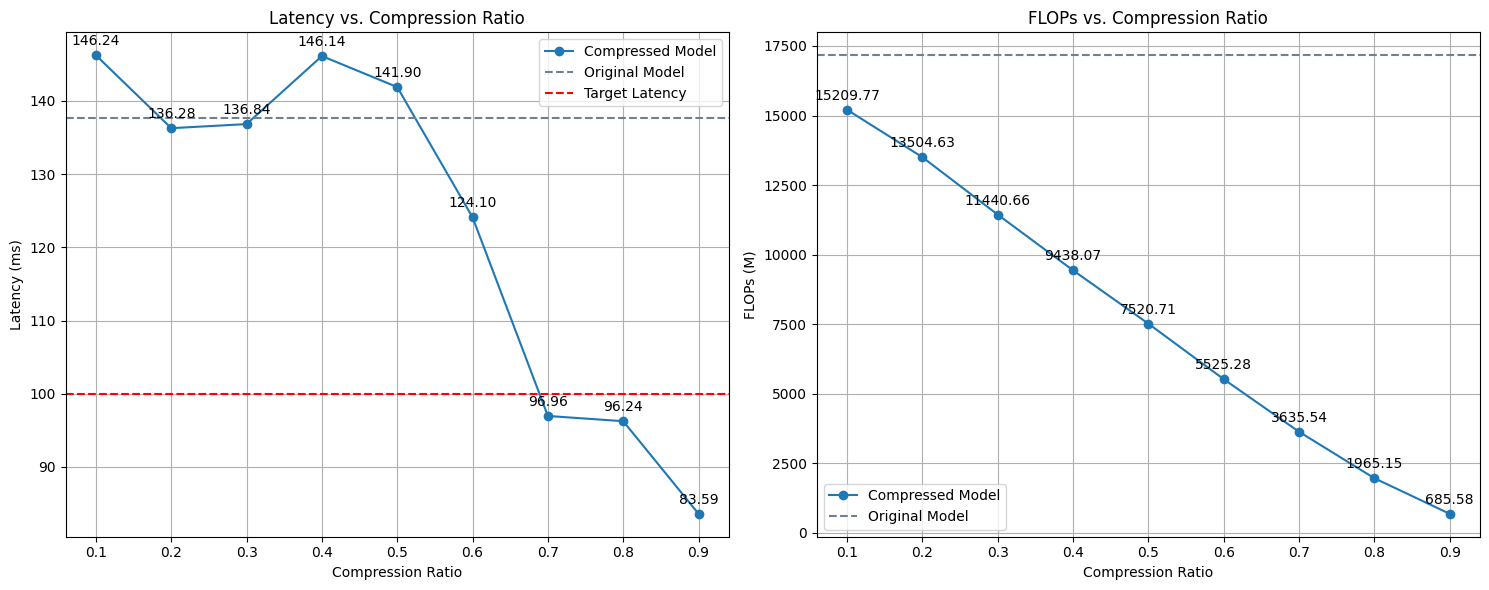

In [21]:
plt.figure(figsize=(15, 6))

# Latency vs. Compression Ratio
plt.subplot(1, 2, 1)
plt.plot(ratios, latency_list, marker='o', label='Compressed Model')
plt.axhline(original_model_latency, color='slategray', linestyle='--', label='Original Model')  # Replace scatter with axhline
plt.axhline(100, color='red', linestyle='--', label='Target Latency')
plt.title('Latency vs. Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('Latency (ms)')
plt.legend()
plt.grid(True)

# Add text annotations for each point
for i, txt in enumerate(latency_list):
    plt.annotate(f'{txt:.2f}', (ratios[i], txt), textcoords="offset points", xytext=(0, 5), ha='center', va='bottom')

plt.annotate(f'{original_model_latency:.2f}', (0, original_model_latency), textcoords="offset points", xytext=(0, 5), ha='center', va='bottom')

# FLOPs vs. Compression Ratio
plt.subplot(1, 2, 2)
plt.plot(ratios, flops_list, marker='o', label='Compressed Model')
plt.axhline(original_model_flops, color='slategray', linestyle='--', label='Original Model')  # Replace scatter with axhline
plt.title('FLOPs vs. Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('FLOPs (M)')
plt.legend()
plt.grid(True)

# Add text annotations for each point
for i, txt in enumerate(flops_list):
    plt.annotate(f'{txt:.2f}', (ratios[i], txt), textcoords="offset points", xytext=(0, 5), ha='center', va='bottom')

plt.annotate(f'{original_model_flops:.2f}', (0, original_model_flops), textcoords="offset points", xytext=(0, 5), ha='center', va='bottom')

plt.tight_layout()
plt.show()

The compression ratio that satisfies **the target latency(100ms)** we set can be found as 0.7, 0.8, and 0.9.

## 4. Retrain the compressed model

Then, we will retrain the compressed model with ratio=0.7 and check the performance.

### 4-1. Train the compressed model

In [22]:
ratio = 0.7
trainer.model.checkpoint = None
trainer.model.fx_model_checkpoint = f"{project_path}/compressed/yolox_auto_compress_{ratio}.pt"
trainer.training.lr = 6e-3

trainer.train(gpus="0,1")

/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2023-12-20_08:42:05 UTC | INFO		| train_common:<trainer_common.py>:39 >>> Task: detection | Model: yolox_s_graphmodule | Training with torch.fx model? True
2023-12-20_08:42:05 UTC | INFO		| build_dataset:<builder.py>:20 >>> -----------

### 4-2. Declare project path

Declare the path of the completed project.

In [23]:
retrained_project_path = "./outputs/detection_yolox_s_graphmodule/version_1"

## 5. Comparison of performance metric between original model and compressed model

Comparing the metric of the original model and the compressed model is as follows.

The plot illustrates comparison between the original and compressed models across different performance metrics. Each subplot corresponds to a specific metric(**mAP50**, **mAP75**, **mAP50_95**).

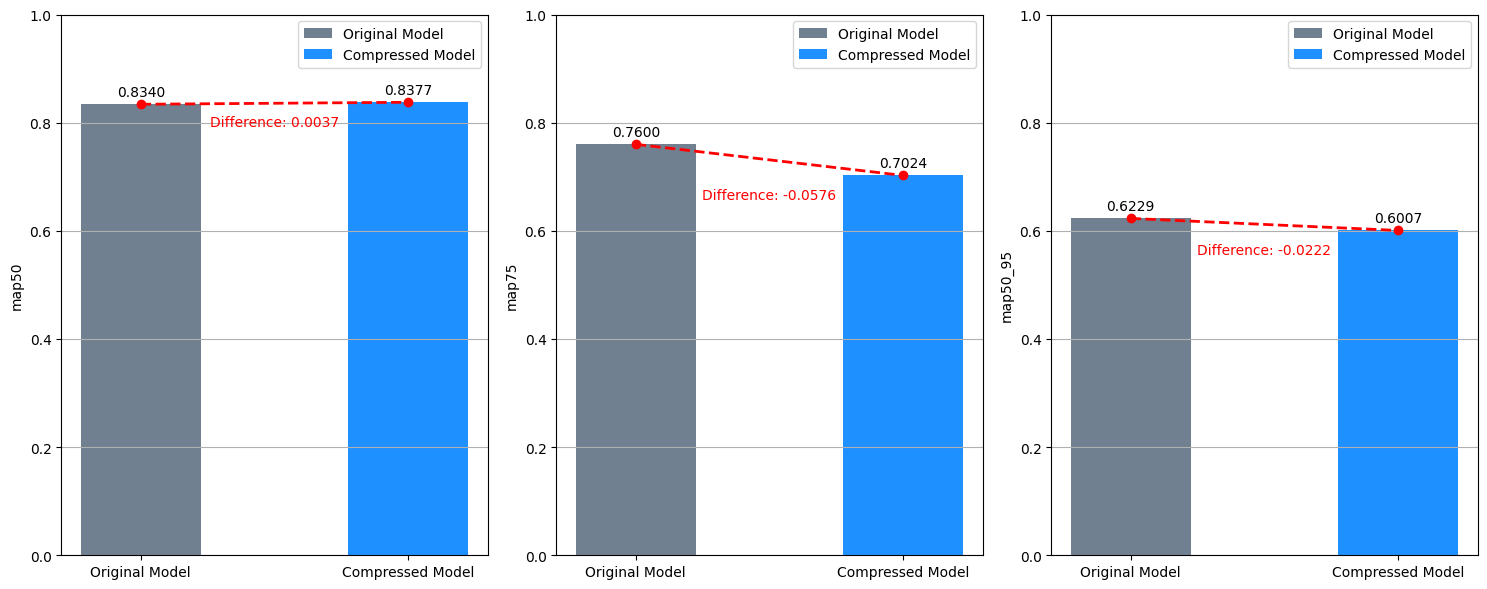

In [24]:
compressed_training_summary_path = f"{retrained_project_path}/training_summary.ckpt"
compressed_training_summary = torch.load(compressed_training_summary_path)
compressed_valid_metrics = compressed_training_summary["valid_metrics"][compressed_training_summary["best_epoch"]]

metrics = list(original_valid_metrics.keys())
original_values = list(original_valid_metrics.values())
compressed_values = list(compressed_valid_metrics.values())

# Calculate the difference between original and compressed values
difference_values = np.array(compressed_values) - np.array(original_values)

# Plotting
fig, axs = plt.subplots(ncols=len(metrics), figsize=(15, 6))

bar_width = 0.45  # Adjust the width as needed

for i, metric in enumerate(metrics):
    bars_original = axs[i].bar(['Original Model'], [original_values[i]], color='slategray', label='Original Model', width=bar_width)
    bars_compressed = axs[i].bar(['Compressed Model'], [compressed_values[i]], color='dodgerblue', label='Compressed Model', width=bar_width)

    # Add value annotations for bars
    for bar in bars_original:
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center', va='bottom')

    for bar in bars_compressed:
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center', va='bottom')

    # Add scatter points for differences
    axs[i].scatter(['Original Model', 'Compressed Model'], [original_values[i], compressed_values[i]], color='red', marker='o', zorder=3)

    # Add lines connecting scatter points
    axs[i].plot(['Original Model', 'Compressed Model'], [original_values[i], compressed_values[i]], color='red', linestyle='--', linewidth=2, zorder=2)

    # Add difference text centered between scatter points
    diff_x = np.mean(axs[i].get_xlim())  # Calculate the center between scatter points
    axs[i].text(diff_x, compressed_values[i] - 0.05, f'Difference: {difference_values[i]:.4f}', ha='center', va='bottom', color='red')

    axs[i].set_ylim(0, 1)  # Set y-axis limits between 0 and 1
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()

For each metric:

- Original Model Bar: Represented by a gray bar labeled "Original Model", indicating the performance metric value of the original model.

- Compressed Model Bar: Represented by a blue bar labeled "Compressed Model", indicating the performance metric value of the compressed model.

- Difference Text: The difference value between the original and compressed models for each metric.

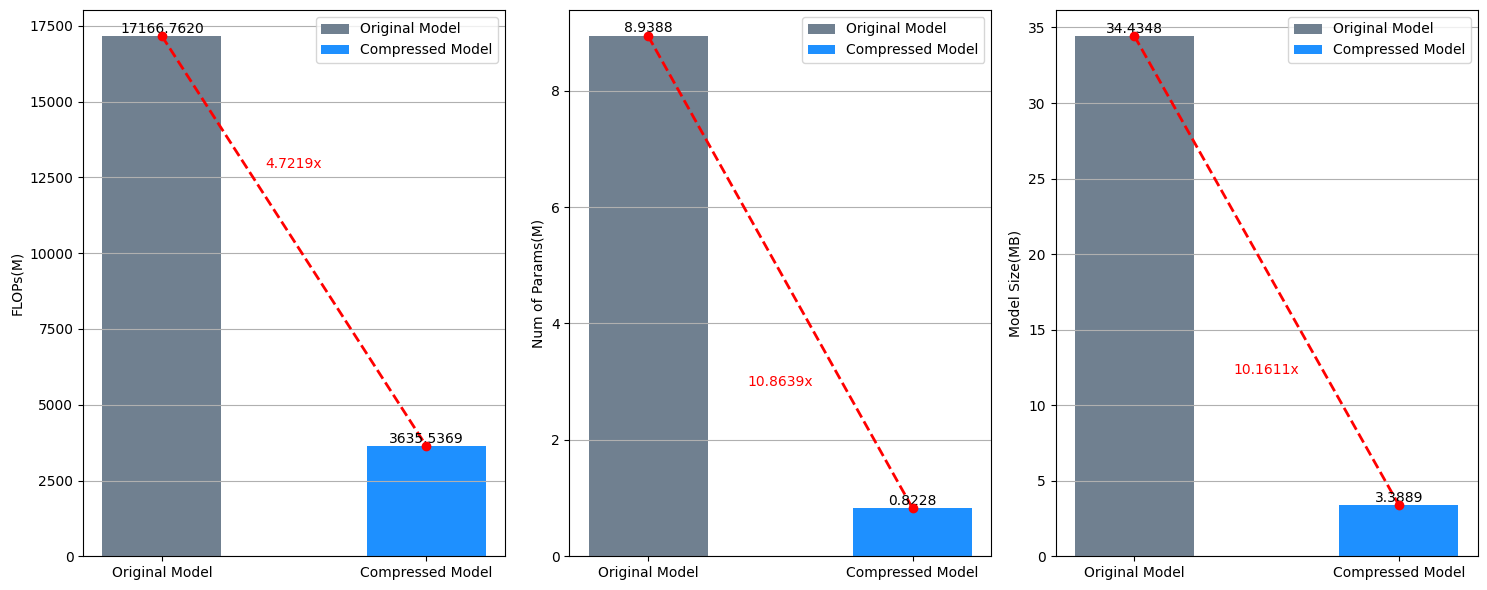

In [25]:
metrics = ["FLOPs(M)","Num of Params(M)", "Model Size(MB)"]
original_values = [original_model_flops, original_model_params, original_model_size]
compressed_values = [flops_list[-3], params_list[-3], model_size_list[-3]]

# Calculate the difference between original and compressed values
difference_values = np.array(original_values) / np.array(compressed_values)

# Plotting
fig, axs = plt.subplots(ncols=len(metrics), figsize=(15, 6))

bar_width = 0.45  # Adjust the width as needed

for i, metric in enumerate(metrics):
    bars_original = axs[i].bar(['Original Model'], [original_values[i]], color='slategray', label='Original Model', width=bar_width)
    bars_compressed = axs[i].bar(['Compressed Model'], [compressed_values[i]], color='dodgerblue', label='Compressed Model', width=bar_width)

    # Add value annotations for bars
    for bar in bars_original:
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center', va='bottom')

    for bar in bars_compressed:
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.4f}', ha='center', va='bottom')

    # Add scatter points for differences
    axs[i].scatter(['Original Model', 'Compressed Model'], [original_values[i], compressed_values[i]], color='red', marker='o', zorder=3)

    # Add lines connecting scatter points
    axs[i].plot(['Original Model', 'Compressed Model'], [original_values[i], compressed_values[i]], color='red', linestyle='--', linewidth=2, zorder=2)

    # Add difference text centered between scatter points
    diff_x = np.mean(axs[i].get_xlim())  # Calculate the center between scatter points
    axs[i].text(diff_x, compressed_values[i] * 3.5, f'{difference_values[i]:.4f}x', ha='center', va='bottom', color='red')

    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()